In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from scipy.stats import median_abs_deviation
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_incidents = pd.read_csv('incidents-clean.csv')

df_incidents.drop(columns=[
    'INCIDENT_NBR',
    'INCIDENT_TYPE_DESC',
    'DESCRIPTION_GROUPE',
    'NOM_VILLE',
    'NOM_ARROND',
    'DIVISION',
    'LATITUDE',
    'LONGITUDE'
], inplace=True)

df_incidents['CREATION_DATE'] = pd.to_datetime(df_incidents['CREATION_DATE'])
df_incidents['YEAR'] = df_incidents['CREATION_DATE'].dt.year
df_incidents['MONTH'] = df_incidents['CREATION_DATE'].dt.month

df_incidents = df_incidents.drop(columns=['CREATION_DATE'])
df_incidents = df_incidents[df_incidents['YEAR'] < 2025]
df_incidents = df_incidents[["YEAR", "MONTH", "CASERNE", "NOMBRE_UNITES", "DESC_GROUP_ENGLISH"]]
df_incidents = df_incidents.rename(columns={'DESC_GROUP_ENGLISH': 'CATEGORY'})
df_incidents.head()

,YEAR,MONTH,CASERNE,NOMBRE_UNITES,CATEGORY
0,2005,1,22,4.0,Other fires
1,2005,1,47,1.0,Other fires
2,2005,1,43,4.0,Other fires
3,2005,1,15,7.0,Building fire
4,2005,1,41,8.0,Building fire


In [3]:
df_incidents_year = df_incidents.groupby(['YEAR', 'CATEGORY']).agg(
  COUNT=('CATEGORY', 'size')
).reset_index()
df_incidents_year.head()

,YEAR,CATEGORY,COUNT
0,2005,Building fire,1637
1,2005,Other fires,3913
2,2006,Building fire,1477
3,2006,Other fires,3402
4,2007,Building fire,1574


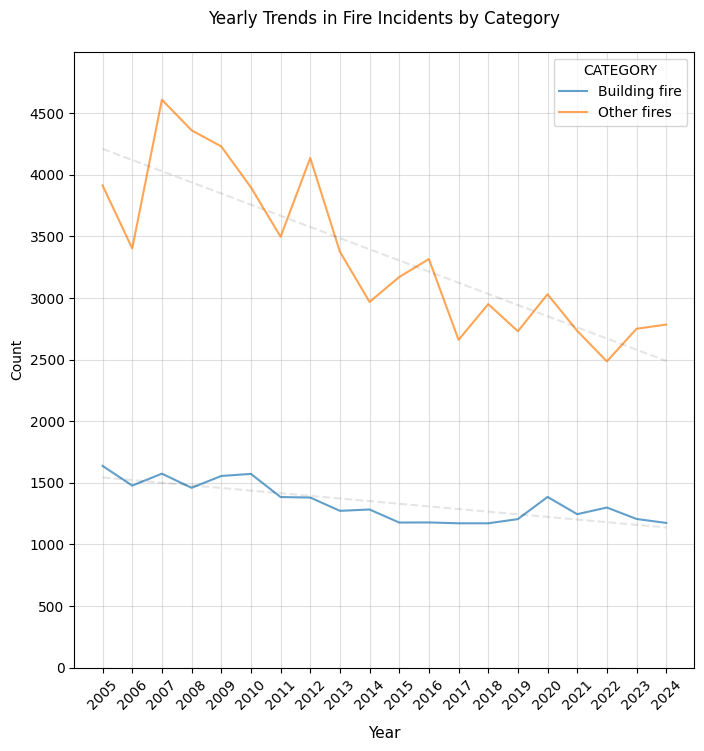

In [4]:
# Create figure and axis
plt.figure(figsize=(8, 8))

df_building_fire = df_incidents_year[df_incidents_year['CATEGORY'] == 'Building fire']
df_other_fires = df_incidents_year[df_incidents_year['CATEGORY'] == 'Other fires']

trend_building = np.polyfit(df_building_fire['YEAR'], df_building_fire['COUNT'], 1)
trend_line_building = np.poly1d(trend_building)

trend_other = np.polyfit(df_other_fires['YEAR'], df_other_fires['COUNT'], 1)
trend_line_other = np.poly1d(trend_other)

ax = sns.lineplot(
  x=df_incidents_year['YEAR'],
  y=df_incidents_year['COUNT'],
  hue=df_incidents_year['CATEGORY'],
  alpha=0.7
)
ax.set_xticks(range(2005,2025))
ax.set_yticks(range(0,5000, 500))
ax.set_ylim(0, 5000)

plt.plot(df_incidents_year['YEAR'], trend_line_building(df_incidents_year['YEAR']), linestyle='--', color='black', alpha=0.1)
plt.plot(df_incidents_year['YEAR'], trend_line_other(df_incidents_year['YEAR']), linestyle='--', color='black', alpha=0.1)

# Show plot
plt.xlabel("Year", fontsize=11, labelpad=10)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Yearly Trends in Fire Incidents by Category", fontsize=12, pad=20)
plt.grid(alpha=0.4)
plt.show()

In [8]:
df_incidents_month = df_incidents.groupby(['YEAR', 'MONTH', 'CATEGORY']).agg(
  COUNT=('CATEGORY', 'size')
).reset_index()
df_incidents_month = df_incidents_month.groupby(['MONTH', 'CATEGORY']).agg(
  COUNT=('COUNT', 'median')
).reset_index()
df_incidents_month['MONTH'] = df_incidents_month['MONTH'].map({
  1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
  6: 'June', 7: 'July', 8: 'August', 9: 'September',
  10: 'October', 11: 'November', 12: 'December'}
)
#df_incidents_month['COUNT'] = df_incidents_month['COUNT'] / (2025 - 2005)
df_incidents_month.head()

,MONTH,CATEGORY,COUNT
0,January,Building fire,105.5
1,January,Other fires,120.0
2,February,Building fire,100.0
3,February,Other fires,103.0
4,March,Building fire,115.0


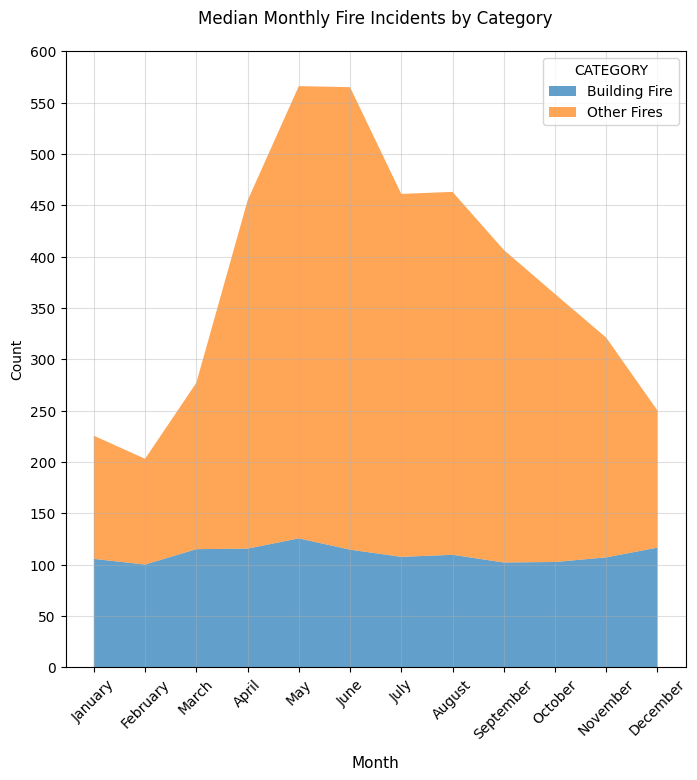

In [9]:
df_building_fire = df_incidents_month[df_incidents_month['CATEGORY'] == 'Building fire']
df_other_fires = df_incidents_month[df_incidents_month['CATEGORY'] == 'Other fires']

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

ax.stackplot(
  df_building_fire['MONTH'],
  df_building_fire['COUNT'],
  df_other_fires['COUNT'],
  #hue=df_incidents_month['CATEGORY'],
  alpha=0.7
)

ax.set_yticks(range(0,650, 50))
#ax.set_ylim(0, 500)


# Show plot
plt.xlabel("Month", fontsize=11, labelpad=10)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Median Monthly Fire Incidents by Category", fontsize=12, pad=20)
plt.grid(alpha=0.4)
plt.legend(['Building Fire', 'Other Fires'], title="CATEGORY")
plt.show()

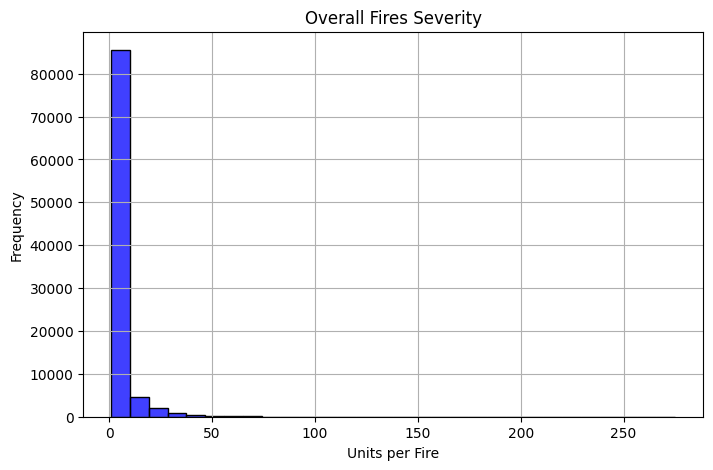

In [10]:
# --- ️Overall Fires Severity Distribution ---
plt.figure(figsize=(8, 5))
sns.histplot(df_incidents["NOMBRE_UNITES"], bins=30, color="blue")
plt.xlabel("Units per Fire")
plt.ylabel("Frequency")
plt.title("Overall Fires Severity")
plt.grid()
plt.show()

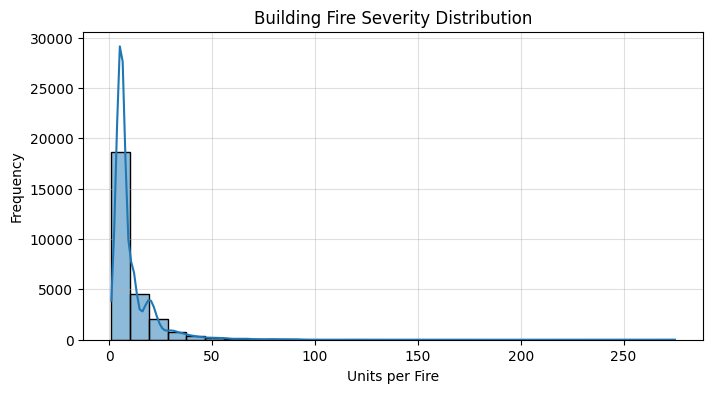

In [22]:
df_building_fire = df_incidents[df_incidents['CATEGORY'] == 'Building fire']

# --- Building Fire Severity Distribution ---
plt.figure(figsize=(8, 4))
sns.histplot(df_building_fire["NOMBRE_UNITES"], bins=30, kde=True)
plt.xlabel("Units per Fire")
plt.ylabel("Frequency")
plt.title("Building Fire Severity Distribution")
plt.grid(alpha=0.4)
plt.show()

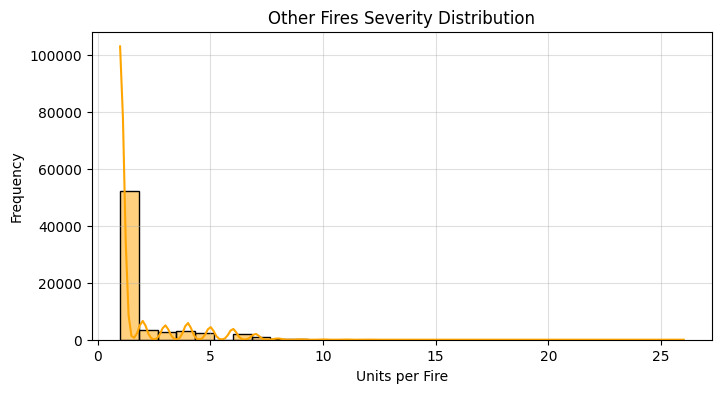

In [23]:
df_other_fires = df_incidents[df_incidents['CATEGORY'] == 'Other fires']

# --- ️Other Fire Severity Distribution ---
plt.figure(figsize=(8, 4))
sns.histplot(df_other_fires["NOMBRE_UNITES"], bins=30, kde=True, color='orange')
plt.xlabel("Units per Fire")
plt.ylabel("Frequency")
plt.title("Other Fires Severity Distribution")
plt.grid(alpha=0.4)
plt.show()

In [24]:
df_severity_month = df_incidents.groupby(['MONTH', 'CATEGORY']).agg(
  MEDIAN_NOMBRE_UNITES=('NOMBRE_UNITES', 'median')
).reset_index()

df_severity_month['MONTH'] = df_severity_month['MONTH'].map({
  1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
  6: 'June', 7: 'July', 8: 'August', 9: 'September',
  10: 'October', 11: 'November', 12: 'December'}
)
df_severity_month.head()

,MONTH,CATEGORY,MEDIAN_NOMBRE_UNITES
0,January,Building fire,7.0
1,January,Other fires,1.0
2,February,Building fire,6.0
3,February,Other fires,1.0
4,March,Building fire,7.0


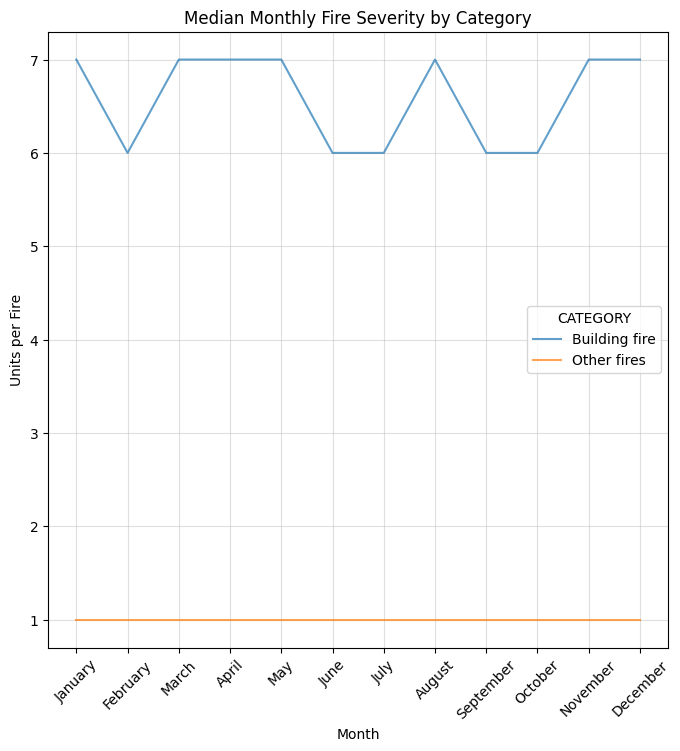

In [25]:
# Create figure and axis
plt.figure(figsize=(8, 8))

#df_building_fire = df_incidents_year[df_incidents_year['CATEGORY'] == 'Building fire']
#df_other_fires = df_incidents_year[df_incidents_year['CATEGORY'] == 'Other fires']

ax = sns.lineplot(
  x=df_severity_month['MONTH'],
  y=df_severity_month['MEDIAN_NOMBRE_UNITES'],
  hue=df_severity_month['CATEGORY'],
  alpha=0.7
)
#ax.set_xticks(range(2005,2025))
#ax.set_yticks(range(0,5000, 500))
#ax.set_ylim(0, 5000)
plt.title("Median Monthly Fire Severity by Category")
plt.xlabel("Month")
plt.ylabel("Units per Fire")
plt.xticks(rotation=45)
plt.grid(alpha=0.4)
plt.show()

In [26]:
df_caserne_month = df_incidents.groupby(['YEAR', 'MONTH', 'CASERNE']).agg(
  MEDIAN_NOMBRE_UNITES=('NOMBRE_UNITES', 'median'),
  FIRE_COUNT=('CASERNE', 'size'),
).reset_index()
df_caserne_month.head()

,YEAR,MONTH,CASERNE,MEDIAN_NOMBRE_UNITES,FIRE_COUNT
0,2005,1,4,8.0,2
1,2005,1,5,4.0,7
2,2005,1,8,3.0,3
3,2005,1,9,4.5,12
4,2005,1,10,8.0,4


In [27]:
df_caserne_month[['MEDIAN_NOMBRE_UNITES', 'FIRE_COUNT']].describe()

,MEDIAN_NOMBRE_UNITES,FIRE_COUNT
count,14585.000000,14585.000000
mean,3.170106,6.431334
std,4.060584,4.779931
min,1.000000,1.000000
25%,1.000000,3.000000
50%,1.500000,5.000000
75%,4.000000,9.000000
max,81.000000,49.000000


In [28]:
df_caserne_area_sq_km = pd.read_csv('caserne-area-sq-km.csv')
df_caserne_area_sq_km.head()

,NO_CAS_ADM,AREA_SQ_KM
0,58,2.28
1,16,2.72
2,35,3.08
3,48,2.28
4,54,9.67


In [29]:
caserne_incidents = pd.Series(df_caserne_month['CASERNE'].unique())
caserne_area = pd.Series(df_caserne_area_sq_km['NO_CAS_ADM'].unique())
caserne_incidents[~caserne_incidents.isin(caserne_area)]

,0
57,79


In [30]:
# Dropping all data related to CASERNE No. 79 => Need to find out which territory absorbed it.
df_caserne_month = df_caserne_month[df_caserne_month['CASERNE'] != 79]
df_caserne_risk = pd.merge(df_caserne_month, df_caserne_area_sq_km, left_on='CASERNE', right_on='NO_CAS_ADM', how='left')
df_caserne_risk.drop(columns=['NO_CAS_ADM'], inplace=True)
df_caserne_risk['FIRE_COUNT_SQ_KM'] = (df_caserne_risk['FIRE_COUNT'] / df_caserne_risk['AREA_SQ_KM']).round(2)
print(df_caserne_risk.shape)
df_caserne_risk.head()

(14543, 7)


,YEAR,MONTH,CASERNE,MEDIAN_NOMBRE_UNITES,FIRE_COUNT,AREA_SQ_KM,FIRE_COUNT_SQ_KM
0,2005,1,4,8.0,2,5.47,0.37
1,2005,1,5,4.0,7,1.31,5.34
2,2005,1,8,3.0,3,12.33,0.24
3,2005,1,9,4.5,12,9.29,1.29
4,2005,1,10,8.0,4,2.65,1.51


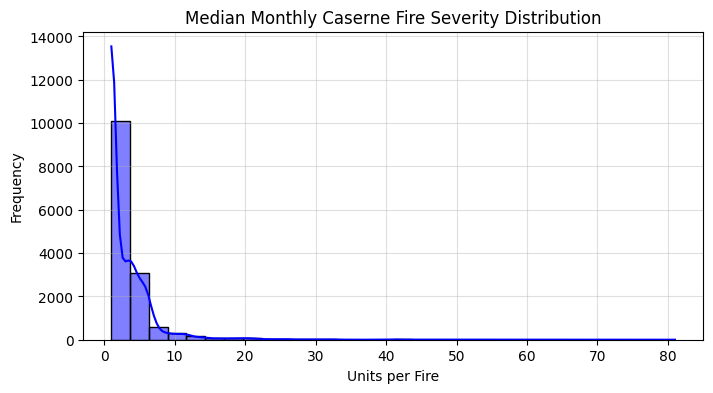

In [31]:
# --- ️Monthly Caserne Median Fire Severity Distribution ---
plt.figure(figsize=(8, 4))
sns.histplot(df_caserne_month["MEDIAN_NOMBRE_UNITES"], bins=30, kde=True, color="blue")
plt.title("Median Monthly Caserne Fire Severity Distribution")
plt.xlabel("Units per Fire")
plt.ylabel("Frequency")
plt.grid(alpha=0.4)
plt.show()

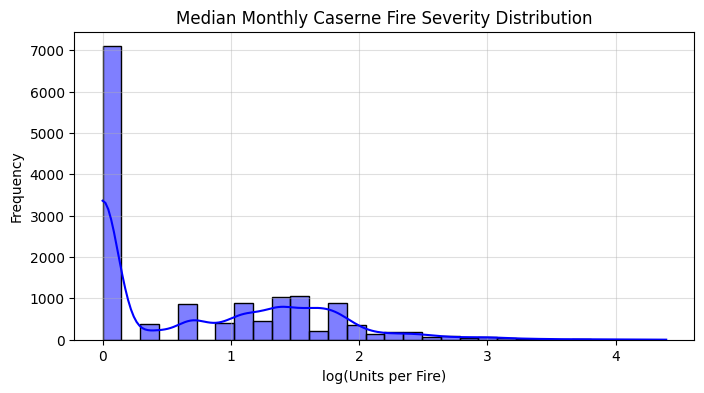

In [46]:
df_caserne_risk['LOG_MEDIAN_NOMBRE_UNITES'] = np.log(df_caserne_risk['MEDIAN_NOMBRE_UNITES'])

# --- ️Monthly Caserne Fire Count Per Square Km  ---
plt.figure(figsize=(8, 4))
sns.histplot(df_caserne_risk["LOG_MEDIAN_NOMBRE_UNITES"], kde=True, bins=30, color="blue")
plt.title(r"Median Monthly Caserne Fire Severity Distribution")
plt.xlabel(r"log(Units per Fire)")
plt.ylabel("Frequency")
plt.grid(alpha=0.4)
plt.show()

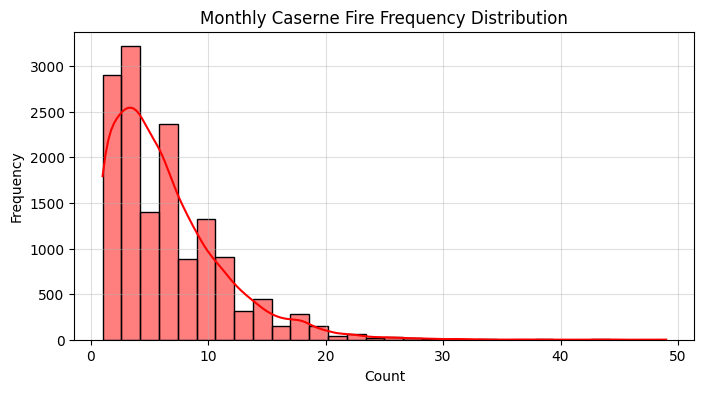

In [33]:
# --- ️Monthly Caserne Fire Count Distribution ---
plt.figure(figsize=(8, 4))
sns.histplot(df_caserne_month["FIRE_COUNT"], kde=True, bins=30, color="red")
plt.title("Monthly Caserne Fire Frequency Distribution")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.grid(alpha=0.4)
plt.show()

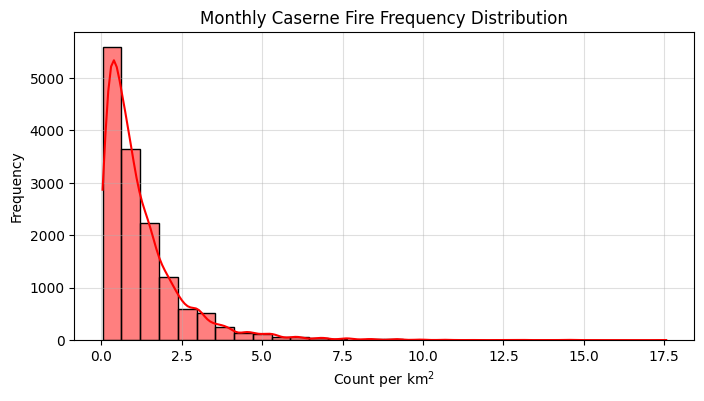

In [34]:
# --- ️Monthly Caserne Fire Count Per Square Km  ---
plt.figure(figsize=(8, 4))
sns.histplot(df_caserne_risk["FIRE_COUNT_SQ_KM"], kde=True, bins=30, color="red")
plt.title(r"Monthly Caserne Fire Frequency Distribution")
plt.xlabel(r"Count per km$^2$")
plt.ylabel("Frequency")
plt.grid(alpha=0.4)
plt.show()

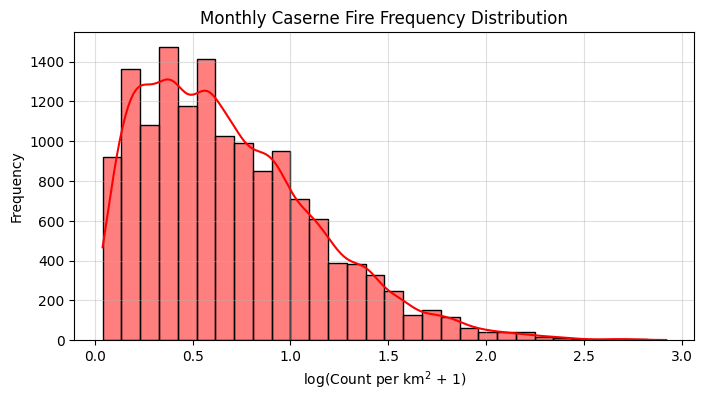

In [35]:
df_caserne_risk['LOG_FIRE_COUNT_SQ_KM'] = np.log(df_caserne_risk['FIRE_COUNT_SQ_KM'] + 1)

# --- ️Monthly Caserne Fire Count Per Square Km  ---
plt.figure(figsize=(8, 4))
sns.histplot(df_caserne_risk["LOG_FIRE_COUNT_SQ_KM"], kde=True, bins=30, color="red")
plt.title(r"Monthly Caserne Fire Frequency Distribution")
plt.xlabel(r"log(Count per km$^2$ + 1)")
plt.ylabel("Frequency")
plt.grid(alpha=0.4)
plt.show()

In [36]:
df_caserne_risk.head()

,YEAR,MONTH,CASERNE,MEDIAN_NOMBRE_UNITES,FIRE_COUNT,AREA_SQ_KM,FIRE_COUNT_SQ_KM,LOG_MEDIAN_NOMBRE_UNITES,LOG_FIRE_COUNT_SQ_KM
0,2005,1,4,8.0,2,5.47,0.37,2.079442,0.314811
1,2005,1,5,4.0,7,1.31,5.34,1.386294,1.846879
2,2005,1,8,3.0,3,12.33,0.24,1.098612,0.215111
3,2005,1,9,4.5,12,9.29,1.29,1.504077,0.828552
4,2005,1,10,8.0,4,2.65,1.51,2.079442,0.920283


In [37]:
scaler = MinMaxScaler()
df_caserne_risk[[
  'SEVERITY_RISK',
  'FREQUENCY_RISK'
]] = scaler.fit_transform(df_caserne_risk[['LOG_MEDIAN_NOMBRE_UNITES', 'LOG_FIRE_COUNT_SQ_KM']]).round(2) * 100

df_caserne_risk.head()

,YEAR,MONTH,CASERNE,MEDIAN_NOMBRE_UNITES,FIRE_COUNT,AREA_SQ_KM,FIRE_COUNT_SQ_KM,LOG_MEDIAN_NOMBRE_UNITES,LOG_FIRE_COUNT_SQ_KM,SEVERITY_RISK,FREQUENCY_RISK
0,2005,1,4,8.0,2,5.47,0.37,2.079442,0.314811,47.0,10.0
1,2005,1,5,4.0,7,1.31,5.34,1.386294,1.846879,32.0,63.0
2,2005,1,8,3.0,3,12.33,0.24,1.098612,0.215111,25.0,6.0
3,2005,1,9,4.5,12,9.29,1.29,1.504077,0.828552,34.0,27.0
4,2005,1,10,8.0,4,2.65,1.51,2.079442,0.920283,47.0,31.0


In [38]:
'''
df_caserne_risk['RISK_SCORE'] = np.log(df_caserne_risk['FREQUENCY_RISK'] * df_caserne_risk['SEVERITY_RISK'] + 1)
df_caserne_risk['RISK_SCORE'] = scaler.fit_transform(df_caserne_risk[['RISK_SCORE']]).round(2) * 100
df_caserne_risk['RISK_SCORE'].describe()
'''

"\ndf_caserne_risk['RISK_SCORE'] = np.log(df_caserne_risk['FREQUENCY_RISK'] * df_caserne_risk['SEVERITY_RISK'] + 1)\ndf_caserne_risk['RISK_SCORE'] = scaler.fit_transform(df_caserne_risk[['RISK_SCORE']]).round(2) * 100\ndf_caserne_risk['RISK_SCORE'].describe()\n"

In [39]:
df_caserne_risk.head()

,YEAR,MONTH,CASERNE,MEDIAN_NOMBRE_UNITES,FIRE_COUNT,AREA_SQ_KM,FIRE_COUNT_SQ_KM,LOG_MEDIAN_NOMBRE_UNITES,LOG_FIRE_COUNT_SQ_KM,SEVERITY_RISK,FREQUENCY_RISK
0,2005,1,4,8.0,2,5.47,0.37,2.079442,0.314811,47.0,10.0
1,2005,1,5,4.0,7,1.31,5.34,1.386294,1.846879,32.0,63.0
2,2005,1,8,3.0,3,12.33,0.24,1.098612,0.215111,25.0,6.0
3,2005,1,9,4.5,12,9.29,1.29,1.504077,0.828552,34.0,27.0
4,2005,1,10,8.0,4,2.65,1.51,2.079442,0.920283,47.0,31.0


In [40]:
'''
# --- ️Monthly Caserne Fire Risk  ---
plt.figure(figsize=(8, 5))
sns.histplot(df_caserne_risk["RISK_SCORE"], kde=True, bins=30, color="blue")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.title("Monthly Caserne Fire Risk Scores")
plt.grid()
plt.show()
'''

'\n# --- ️Monthly Caserne Fire Risk  ---\nplt.figure(figsize=(8, 5))\nsns.histplot(df_caserne_risk["RISK_SCORE"], kde=True, bins=30, color="blue")\nplt.xlabel("Risk Score")\nplt.ylabel("Frequency")\nplt.title("Monthly Caserne Fire Risk Scores")\nplt.grid()\nplt.show()\n'

### Modified Z-Score Formula (Using MAD)

$$
MZ = \frac{0.6745 \times (X_i - \text{Median})}{\text{MAD}}
$$

$MZ>3.5$ → The point is an outlier.

In [41]:
def detect_outliers(data, threshold=3.5):
    median = np.median(data)
    mad = median_abs_deviation(data)
    mod_z_scores = 0.6745 * (data - median) / mad
    outliers = data[np.abs(mod_z_scores) > threshold]
    return outliers

In [42]:
#outliers = detect_outliers(df_caserne_risk['RISK_SCORE'])
#outliers.describe()

In [43]:
#df_caserne_risk['RISK_SCORE'] = winsorize(df_caserne_risk['RISK_SCORE'], limits=[0.01, 0.01])
#outliers = detect_outliers(df_caserne_risk['RISK_SCORE'])
#outliers.describe()

In [44]:
df_caserne_risk.to_csv('caserne-risk.csv', index=False)